In [19]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import time
import cv2

from joblib import Parallel, delayed

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *

from matplotlib.path import Path
%matplotlib inline

import math
import random

In [20]:
labels = ['BackG', '5N', '7n', '7N', '12N', 'Pn', 'VLL', 
          '6N', 'Amb', 'R', 'Tz', 'RtTg', 'LRt', 'LC', 'AP', 'sp5']

n_labels = len(labels)

labels_index = dict((j, i) for i, j in enumerate(labels))

labels_from_surround = dict( (l+'_surround', l) for l in labels[1:])

labels_surroundIncluded_list = labels[1:] + [l+'_surround' for l in labels[1:]]
labels_surroundIncluded = set(labels_surroundIncluded_list)

labels_surroundIncluded_index = dict((j, i) for i, j in enumerate(labels_surroundIncluded_list))

# colors = np.random.randint(0, 255, (len(labels_index), 3))
colors = np.loadtxt(os.environ['REPO_DIR'] + '/visualization/100colors.txt')
colors[labels_index['BackG']] = 1.

In [21]:
# build training data

# sift_dir = '/oasis/projects/nsf/csd395/yuncong/Brain/learning/sift'
sift_dir = '/oasis/projects/nsf/csd395/wel144/2016-brainstem/sift'

train_data = []
train_labels = []

n_sample = 1000

for name in labels[1:]:
    train_hists0 = bp.unpack_ndarray_file(sift_dir + '/train/MD589_%(name)s_histograms_l0.bp' % {'name': name})
    train_hists1 = bp.unpack_ndarray_file(sift_dir + '/train/MD589_%(name)s_histograms_l1.bp' % {'name': name})
    train_hists2 = bp.unpack_ndarray_file(sift_dir + '/train/MD589_%(name)s_histograms_l2.bp' % {'name': name})
    
    n_train = train_hists0.shape[0]
    print (name, n_train),

    #     train_hists = np.c_[train_hists0, train_hists1.reshape((n_train, -1)), train_hists2.reshape((n_train, -1))]

    random_indices = np.random.choice(range(n_train), min(n_train, n_sample), replace=False)
    n_train = len(random_indices)
    train_hists = np.c_[train_hists0[random_indices], 
                        train_hists1[random_indices].reshape((n_train, -1)), 
                        train_hists2[random_indices].reshape((n_train, -1))]
    
    train_data.append(train_hists)
    train_labels.append(np.ones((n_train, )) * labels_index[name])
    print n_train
    

train_data = np.concatenate(train_data)
train_labels = np.concatenate(train_labels)
n_train = train_data.shape[0]

('5N', 1440) 1000
('7n', 3444) 1000
('7N', 2579) 1000
('12N', 1230) 1000
('Pn', 3042) 1000
('VLL', 1287) 1000
('6N', 154) 154
('Amb', 346) 346
('R', 1082) 1000
('Tz', 1387) 1000
('RtTg', 2639) 1000
('LRt', 1050) 1000
('LC', 481) 481
('AP', 483) 483
('sp5', 3240) 1000


In [22]:
train_data.shape

(12464, 4200)

In [23]:
train_data_normalized = train_data / train_data.sum(axis=1)[:,None].astype(np.float)
train_data_normalized = np.nan_to_num(train_data_normalized)

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':


In [24]:
bp.pack_ndarray_file(train_data_normalized, 'preprocessed/train_data.bp')
# bp.pack_ndarray_file(train_data, 'preprocessed/train_data.bp')
bp.pack_ndarray_file(train_labels, 'preprocessed/train_labels.bp')

In [25]:
# build testing data

stack = 'MD585'

first_detect_sec, last_detect_sec = detect_bbox_range_lookup[stack]

sec = first_detect_sec

test_hists0 = bp.unpack_ndarray_file(sift_dir + '/%(stack)s/%(stack)s_%(sec)04d_roi1_histograms_l0.bp' % {'stack': stack, 'sec': sec})
test_hists1 = bp.unpack_ndarray_file(sift_dir + '/%(stack)s/%(stack)s_%(sec)04d_roi1_histograms_l1.bp' % {'stack': stack, 'sec': sec})
test_hists2 = bp.unpack_ndarray_file(sift_dir + '/%(stack)s/%(stack)s_%(sec)04d_roi1_histograms_l2.bp' % {'stack': stack, 'sec': sec})

n_test = test_hists0.shape[0]
test_hists = np.c_[test_hists0, test_hists1.reshape((n_test, -1)), test_hists2.reshape((n_test, -1))]

test_data = test_hists

In [26]:
test_data.shape

(20979, 4200)

In [27]:
test_data_normalized = test_data / test_data.sum(axis=1)[:,None].astype(np.float)

In [28]:
bp.pack_ndarray_file(test_data_normalized, 'preprocessed/%(stack)s_test_data.bp' % {'stack': stack})
# bp.pack_ndarray_file(test_data, 'preprocessed/%(stack)s_test_data.bp' % {'stack': stack})

In [29]:
# method 1
t = time.time()

def compute_intersection_kernel_oneJob(i, j1):
#     dist = .5 * np.sum(train_data_normalized + h - np.abs(train_data_normalized - h), axis=1)
    dist = np.minimum(train_data_normalized[i], train_data_normalized[j1:]).sum(axis=1)
#     dist = np.minimum(train_data[i], train_data[j1:]).sum(axis=1)
    return dist

train_dist_triangle = np.concatenate(Parallel(n_jobs=16)(delayed(compute_intersection_kernel_oneJob)(i, i) 
                                     for i in range(n_train)))

sys.stderr.write('compute intersection kernel: %f seconds\n' % (time.time() - t)) # ~ 200s / 12k training data

train_dist_mat = np.empty((n_train, n_train))
train_dist_mat[np.triu_indices(n_train)] = train_dist_triangle
r = np.tril_indices(n_train)
train_dist_mat[r] = train_dist_mat.T[r]


compute intersection kernel: 192.439459 seconds


In [30]:
# method 2
t = time.time()

def compute_intersection_kernel_oneJob(h):
#     dist = .5 * np.sum(train_data_normalized + h - np.abs(train_data_normalized - h), axis=1)
    dist = np.minimum(train_data_normalized, h).sum(axis=1)
    return dist

# train_dist_mat = np.array(Parallel(n_jobs=16)(delayed(compute_intersection_kernel_oneJob)(h) 
#                                      for h in train_data_normalized[:1000]))

sys.stderr.write('compute intersection kernel: %f seconds\n' % (time.time() - t)) # ~ 400s / 12k training data

compute intersection kernel: 0.000318 seconds


In [31]:
# method 3
t = time.time()

def compute_intersection_kernel_oneJob(i, ni, j, nj):
    dists = np.minimum(train_data_normalized[i:i+ni, None], train_data_normalized[j:j+nj]).sum(axis=-1)
    return dists

# train_dist_mat = np.empty((n_train, n_train))
# ni = 100
# nj = 100
# for j in range(0, n_train, nj):
#     train_dist_mat[:, j:j+nj] = np.concatenate(Parallel(n_jobs=16)(delayed(compute_intersection_kernel_oneJob)(i, ni, j, nj) 
#                                                     for i in range(0, n_train, ni)))

sys.stderr.write('compute intersection kernel: %f seconds\n' % (time.time() - t)) # ~ 400s / 12k training data

compute intersection kernel: 0.000340 seconds


In [32]:
train_dist_mat.shape

(12464, 12464)

In [33]:
bp.pack_ndarray_file(train_dist_mat, 'preprocessed/train_spm_dist_mat.bp')

In [42]:
class Hypersphere_abstain:
    
    def __init__(self, center, radius, threshold, label, alpha, acc, unweighted_acc,
                 label_distribution, center_index, neighbor_indices):
        
        self.center = center
        self.radius = radius
        self.thres = threshold
        self.label = label
        self.alpha = alpha
        self.acc = acc # Weighted accuracy
        self.unweighted_acc = unweighted_acc
        self.label_distribution = label_distribution
        self.center_index = center_index
        self.neighbor_indices = neighbor_indices



t:  0
exemplar label:  1.0
interest label:  1
percentage:  0.28
Abstain

t:  1
exemplar label:  6.0
interest label:  6
percentage:  0.3
Abstain

t:  2
exemplar label:  4.0
interest label:  4
percentage:  0.36
Abstain

t:  3
exemplar label:  10.0
interest label:  10
percentage:  0.32
Abstain

t:  4
exemplar label:  12.0
interest label:  4
percentage:  0.3
Abstain

t:  5
exemplar label:  6.0
interest label:  4
percentage:  0.4
Abstain

t:  6
exemplar label:  12.0
interest label:  5
percentage:  0.24
Abstain

t:  7
exemplar label:  12.0
interest label:  6
percentage:  0.22
Abstain

t:  8
exemplar label:  2.0
interest label:  2
percentage:  0.6
(60, 0.61666666666666725)
weighted_acc:  0.616666666667
alpha:  0.237711848308
acc:  0.616666666667
[ 0  0 37  0  0  0  0  0  0  0  0  1  0  0  0 22]


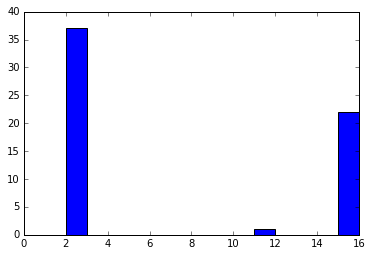


t:  9
exemplar label:  1.0
interest label:  4
percentage:  0.48
Abstain
(1, array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]), array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))


In [45]:
# Adaboost.M1

# Load preprocessed data
X = bp.unpack_ndarray_file('preprocessed/train_data.bp')
y = bp.unpack_ndarray_file('preprocessed/train_labels.bp')
train_kernel = bp.unpack_ndarray_file('preprocessed/train_spm_dist_mat.bp')

# Initialization
n_samples = X.shape[0]
D = 1.0 / n_samples * np.ones((n_samples, ))
T = 10
H = []

# WeakLearner initialization
init_radius = 50
thres_abstain = 0.5
growth_radius = 10

for t in xrange(0, T):
    
    print '\nt: ', t

    # Choose an exemplar
    exemplar_index = np.random.choice(range(n_samples), p=D.tolist())
    exemplar = X[exemplar_index]
#     print 'exemplar: ', exemplar_index
    print 'exemplar label: ', y[exemplar_index]
    
    # Calculate dist to all other
    scores = train_kernel[exemplar_index]
    sorted_scores = np.sort(scores)[::-1]
    sorted_indices = np.argsort(scores)[::-1]
    sorted_X = X[sorted_indices]
    sorted_y = y[sorted_indices].astype('int64')
    sorted_D = D[sorted_indices]
#     print sorted_y[:10]
#     print sorted_scores[:10]
#     print sorted_scores[-10:]
    
    # Calculate plurarity of initial sphere & abstain
    count = np.bincount(sorted_y[:init_radius],
                        weights=sorted_D[:init_radius],
                        minlength=16)
    unweighted_count = np.bincount(sorted_y[:init_radius],
                                   minlength=16)
    y_of_interest = np.argmax(count)
#     print count, np.sum(sorted_D[:init_radius]), len(count)
#     print unweighted_count, len(count)
    print 'interest label: ', y_of_interest
    
    percentage = count[y_of_interest]*1.0 / np.sum(sorted_D[:init_radius])
    print 'percentage: ', percentage
    
    # Abstain test
    if percentage<thres_abstain:
        print "Abstain"
        continue
    
    # Caculate best radius
    index_of_interest = np.array([y_==y_of_interest for y_ in sorted_y])
    weight_of_interest = np.cumsum(index_of_interest*sorted_D)
    best_radius = init_radius
    best_percentage = percentage
    for i in range(init_radius+growth_radius, n_samples, growth_radius):
        perc = weight_of_interest[i-1]*1.0 / np.sum(sorted_D[:i])
        if perc>best_percentage:
            best_radius = i
            best_percentage = perc
#         print (i, perc)
    print (best_radius, best_percentage)
    
    # Alpha
    w_total = np.sum(sorted_D[:best_radius])
    w_acc = weight_of_interest[best_radius-1]*1.0 / w_total
    w_err = 1.0 - w_acc
#     print 'weighted_total: ', w_total
    print 'weighted_acc: ', w_acc
#     print 'weighted_err: ', w_err
    
    epsilon = 1.0e-10
    alpha = 0.5 * math.log((w_acc+epsilon)/(w_err+epsilon))
    print 'alpha: ', alpha
    
    # Reweight
    index_of_other = ~index_of_interest
#     print 'labels: ', y[:20]
    D[sorted_indices] = D[sorted_indices] + index_of_interest*math.exp(-1.0*alpha)
#     print 'interest: ', D[:20]
    D[sorted_indices] = D[sorted_indices] + index_of_other*math.exp(alpha)
#     print 'others: ', D[:20]
    
    # Normalize
    D = D*1.0 / np.sum(D)
#     print 'reweighted sum: ', np.sum(D)
    
    # Append WeakLearner to list
    acc = np.sum(index_of_interest[:best_radius])*1.0 / best_radius
    threshold = sorted_scores[best_radius-1]
    label_distribution = np.bincount(sorted_y[:best_radius], minlength=16)
    print 'acc: ', acc
    print label_distribution
    plt.bar(np.arange(0,16), label_distribution, width=1)
    plt.show()
    
    h = Hypersphere_abstain(exemplar, best_radius, threshold, y_of_interest,
                            alpha, w_acc, acc, label_distribution,
                            exemplar_index, sorted_indices)
    H.append(h)
    

# Predict

result = []
n_samples = train_kernel.shape[1] # n_test

for i in range(1, len(H)+1):
    
    classifiers = H[:i]
    prob = np.zeros((n_samples, 16))
    for clf in classifiers:   
        score = np.copy(train_kernel[clf.center_index])
        score[score < clf.thres] = 0
        score[score >= clf.thres] = clf.alpha
        prob[:,clf.label] += score
    max_prob = np.max(prob, axis=1)
    labels = np.argmax(prob, axis=1)
    labels[max_prob==0] = 0
    print (i, y[:10], max_prob[:10], labels[:10])

    


In [ ]:
# Adaboost.M2

# train_data = train_data
# train_labels = train_labels

# n_train = train_data.shape[0]

# D = 1.0 / n_train * np.ones((n_train, ))

# W = np.ones((n_train, ))

# choose exemplar

# compute accuracy of exemplar

# choose the plurality

# compute threshold

# reweight samples

# store hypersphere


